(365, 5)


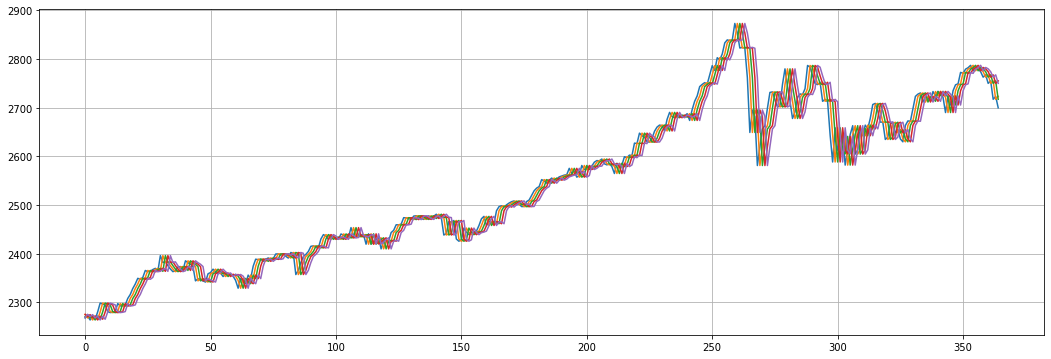

In [2]:
import pandas as pd
import requests
import numpy as np
from sklearn.decomposition import FastICA
from io import StringIO
from scipy import signal
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

#Datos cargados desde drive
orig_url='https://drive.google.com/file/d/1lPNRzlmfm0iT-HV8mLCIdzvt3zNpu5nN/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
sp500 = pd.read_csv(csv_raw)

# Señal deseada
d = sp500.close.iloc[-366:-1].to_numpy().reshape(-1,1)
# Señal de entrada
u1 = sp500.close.iloc[-367:-2].to_numpy().reshape(-1,1)
u2 = sp500.close.iloc[-368:-3].to_numpy().reshape(-1,1)
u3 = sp500.close.iloc[-369:-4].to_numpy().reshape(-1,1)
u4 = sp500.close.iloc[-370:-5].to_numpy().reshape(-1,1)
u5 = sp500.close.iloc[-371:-6].to_numpy().reshape(-1,1)
u = np.concatenate((u1,u2,u3,u4,u5), axis=1)
# Grafica de la entrada
plt.figure(figsize=(18, 6))
print(u.shape)
plt.plot(u)
plt.grid()
plt.show()

In [0]:
class QKLMS:
  def __init__(self, eta=None, epsilon=None, sigma=None):
    if eta == None:
      self.eta = 0.9 #Remplazar por algun criterio
    else:
      self.eta = eta
    if epsilon == None:
      self.epsilon = 10 #Remplazar por algun criterio
    else:
      self.epsilon = epsilon
    if sigma == None:
      from scipy.spatial.distance import cdist
      d_sgm = cdist(u,u)
      self.sigma = np.median(d_sgm) #Criterio de la mediana      
    else:
      self.sigma = sigma
    self.CB = [] #Codebook
    self.a_coef = [] #Coeficientes
    self.CB_cov = [] #Covarianzas
    self.__means = [] 
    self.CB_growth = [] #Crecimiento del codebook por iteracion 
    
  def evaluate(self, u , d):
    if u.shape[0]!=d.shape[0]:
      raise ValueError('All of the input arguments must be of the same lenght')
    #Tamaños
    N,D = u.shape
    Nd,Dd = d.shape
    #Inicializaciones
    self.CB.append(u[0,:]) #Codebook
    self.a_coef.append(self.eta*d[0,:]) #Coeficientes
    self.CB_cov.append(np.var(u[0,:], ddof=1)*np.eye(D)) #Covarianzas
    #Salida
    y = np.empty((Nd,Dd))
    i = 1
    # err = 0.1

    while True:
      yi,disti = self.__output(u[i,:].reshape(-1,D)) #Salida
      d_mahal = self.__dmahal(u[i,:].reshape(-1,D)) #Distancia de Mahalanobis 
      # self.__newEta(yi,err) #Nuevo eta
      err = d[i] - yi # Error
      #Cuantizacion
      min_index = np.argmin(d_mahal)#disti
      if disti[min_index] <= self.epsilon:
        self.a_coef[min_index] =(self.a_coef[min_index] + self.eta*err).item()
      else:
        self.CB.append(u[i,:])
        self.a_coef.append((self.eta*err).item())
        self.CB_cov.append(np.var(u[i,:], ddof=1)*np.eye(D))
      self.CB_growth.append(len(self.CB)) #Crecimiento del diccionario 
      y[i-1] = yi
      i+=1      
      if(i == N-1):
        return y

  def __output(self,ui):
    dist = cdist(np.asarray(self.CB), ui)
    K = np.exp(-0.5*(dist**2)/(self.sigma**2))
    y = K.T.dot(np.asarray(self.a_coef))
    return [y,dist]

  def __newEta(self, y, errp):
    # y: Salida calculada
    # errp: Error a priori 
    self.eta = (2*errp*y)/(errp**2 + 1)
    return False

  def __dmahal(self,ui):
    from scipy.spatial import distance
    i = 0
    dist_m = np.array([])
    while i < len(self.CB):    
      # VI = np.linalg.inv(np.trace(np.cov(np.asarray(self.CB)[i], ui))*np.eye(ui.shape[1]))
      d_i = distance.mahalanobis(np.asarray(self.CB)[i],ui,self.CB_cov[i])
      dist_m = np.concatenate((dist_m,[d_i]))
      i+=1
    return dist_m


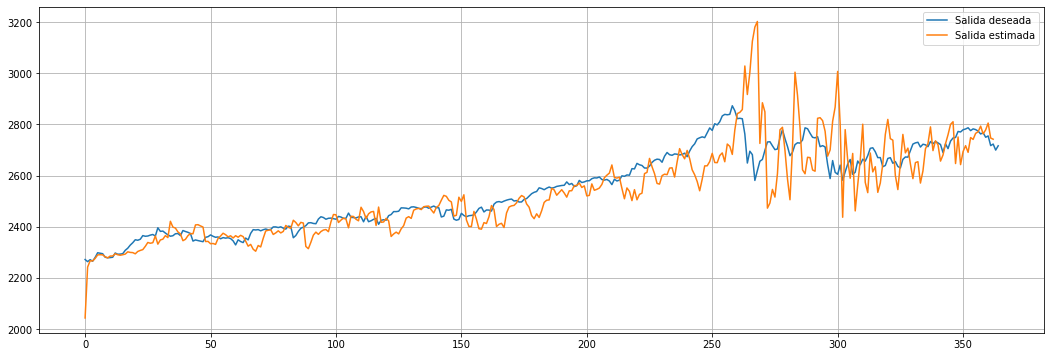

In [13]:
qklms = QKLMS()
y = qklms.evaluate(u,d)

plt.figure(figsize=(18, 6))
plt.grid()
plt.plot(d, label="Salida deseada")
plt.plot(y[:-2], label="Salida estimada")
plt.legend()

a size:  (326,)
CB size:  (326, 5)


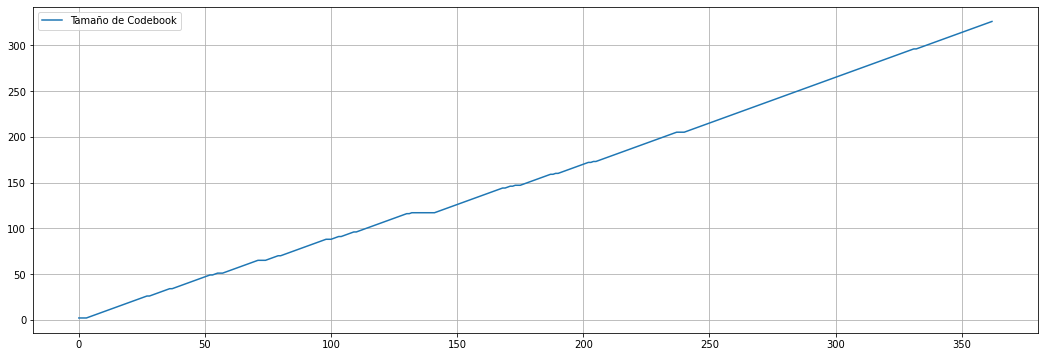

In [0]:
plt.figure(figsize=(18, 6))
plt.plot(np.asarray(qklms.CB_growth), label="Tamaño de Codebook")
plt.grid()
plt.legend()
print("a size: ", np.asarray(qklms.a_coef).shape)
print("CB size: ", np.asarray(qklms.CB).shape)

x1 :  [2267.89 2274.64 2270.44 2275.32 2268.9 ]
y1 :  [2271.89 2267.89 2274.64 2270.44 2275.32]
Covarianza: 
 [[11.33712  -7.471685]
 [-7.471685  9.33083 ]]
Varianza:  11.337120000000198


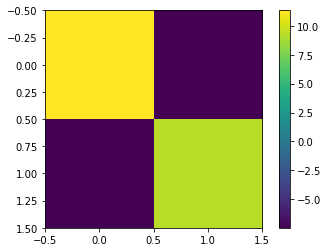

In [0]:
x1 = np.asarray(qklms.CB[0])
y1 = u[1]
print("x1 : ", x1)
print("y1 : ", y1)
cov = np.cov(x1,y1)
print("Covarianza: \n",cov)
print("Varianza: ", np.var(x1,ddof=1))
plt.imshow(cov)
plt.colorbar()

Distancia de Mahalanobis cdist vs distance.mahalanobis. ¿Por qué se obtienen estos resultados?


In [0]:
XA = np.asarray(qklms.CB[0])
XB = u[1]
print("XA:\n",XA.shape,"\nXB:\n",XB)
S = np.linalg.inv(np.trace(np.cov(XA,XB))*np.eye(u.shape[1]))
cdist(XB.reshape(-1,1),XA.reshape(-1,1), metric='mahalanobis', VI=S) 

In [0]:
from scipy.spatial import distance
distance.mahalanobis(XA,XB,S)

Matriz de gram para QKLMS


h con criterio de mediana:  354.78043886324986
h con criterio de silverman:  3.851947210271794e-11


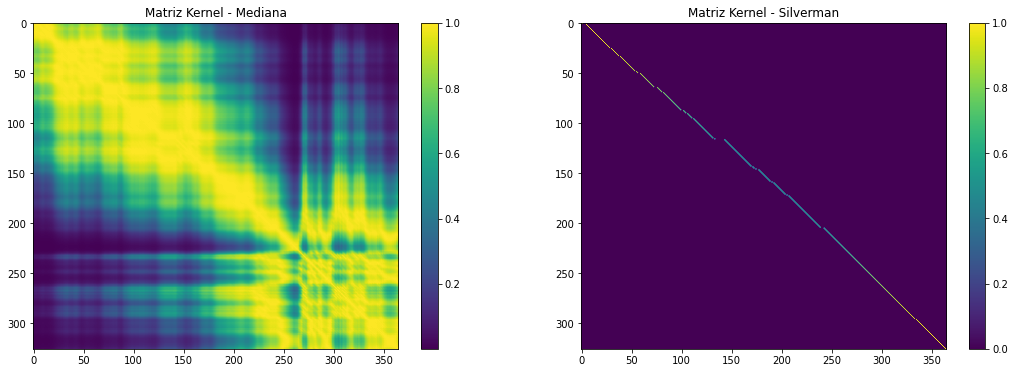

In [0]:
# Usando criterio de la mediana
dist = cdist(np.asarray(qklms.CB),u)
h = np.median(dist)
print("h con criterio de mediana: ",h)
K = np.exp((-0.5*dist**2)/(h**2))

# Usando silverman
N_total, dims= u.shape
stdDev = np.std(u)
h2 = stdDev*(4/(N_total*(2*dims+1)))**(1/dims+4)
print("h con criterio de silverman: ",h2)
K2 = np.exp((-0.5*dist**2)/(h2**2))

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.imshow(K)
plt.title('Matriz Kernel - Mediana')
plt.colorbar()
plt.subplot(122)
plt.imshow(K2)
plt.title('Matriz Kernel - Silverman')
plt.colorbar()
plt.show()


In [10]:
#prueba covarianza online
def online_covariance(data1, data2):
    meanx = meany = C = n = 0
    for x, y in zip(data1, data2):
        n += 1
        dx = x - meanx
        meanx += dx / n
        meany += (y - meany) / n
        C += dx * (y - meany)
    population_covar = C / n
    # Bessel's correction for sample variance
    sample_covar = C / (n - 1)
    return sample_covar

    
x1 = np.asarray(qklms.CB[0])
y1 = u[1]
online_covariance(x1,x1)

11.337120000000104